# Вебинар 4. Обучение с учителем.

**План занятия**
* [Введение](#intro)
* [Шаг 1. Загрузка данных](#load)
* [Шаг 2. EDA и очистка данных](#eda)
* [Шаг 3: Очистка данных и Feature engineering](#preprocess)
* [Шаг 4. Разбиение на train / test](#split)
* [Шаг 5. Построение моделей](#model)
    * [5.1 Linear Regression](#linear)
    * [5.2 Decision tree](#tree)
    * [5.3 Random Forest](#rf)
    * [5.4 Gradient Boosting decision trees](#boost)
* [Шаг 6. Настройка и оценка финальной модели](#cross_val)
* [Шаг 7. Анализ прогнозов](#pred)
* [Шаг 8. Сохранение модели](#save)
* [Обобщение](#full)

## Введение <a class='anchor' id='intro'>

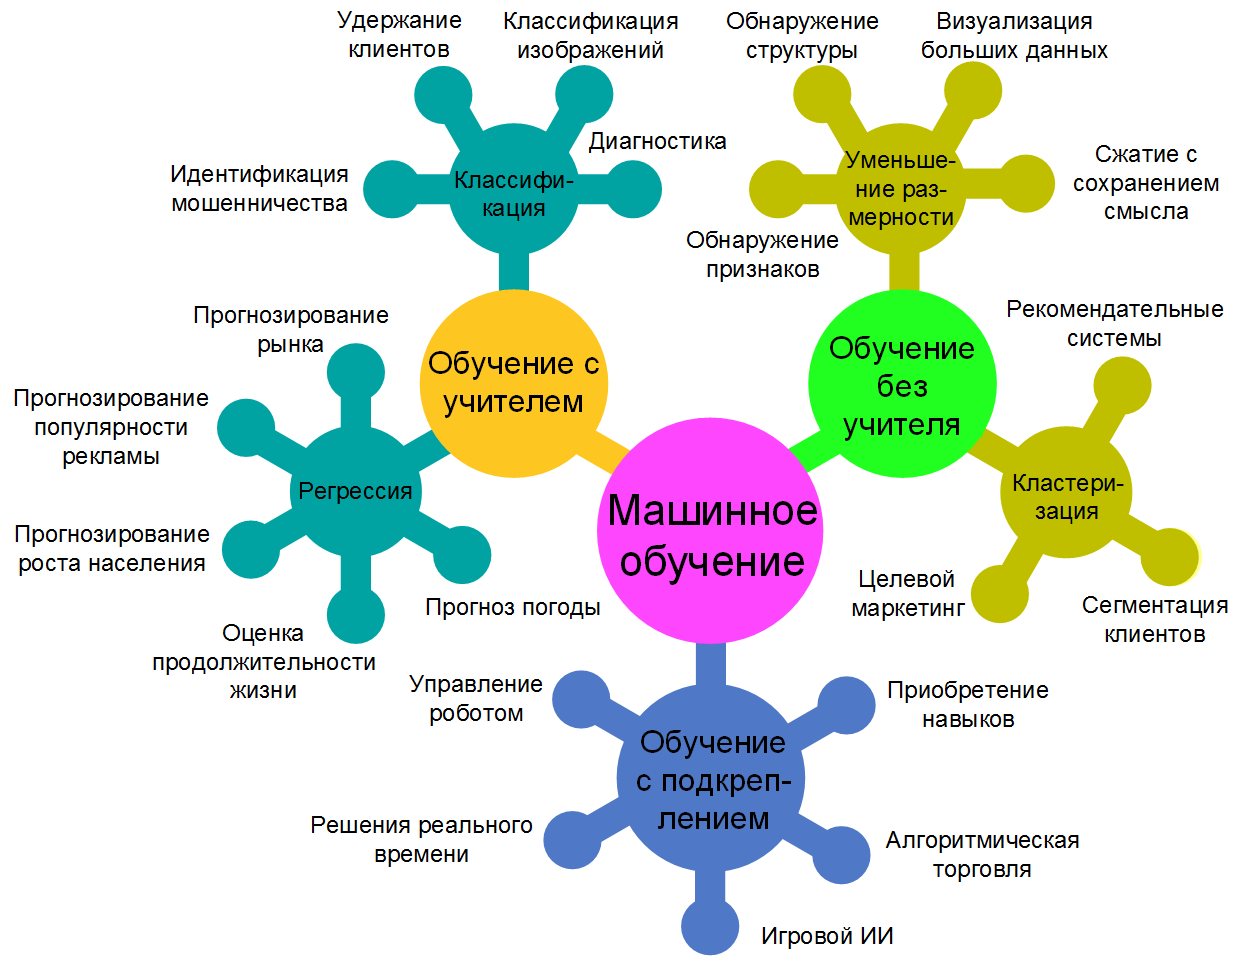 

**Обучение с учителем** = есть целевая переменная (таргет), которую мы предсказываем

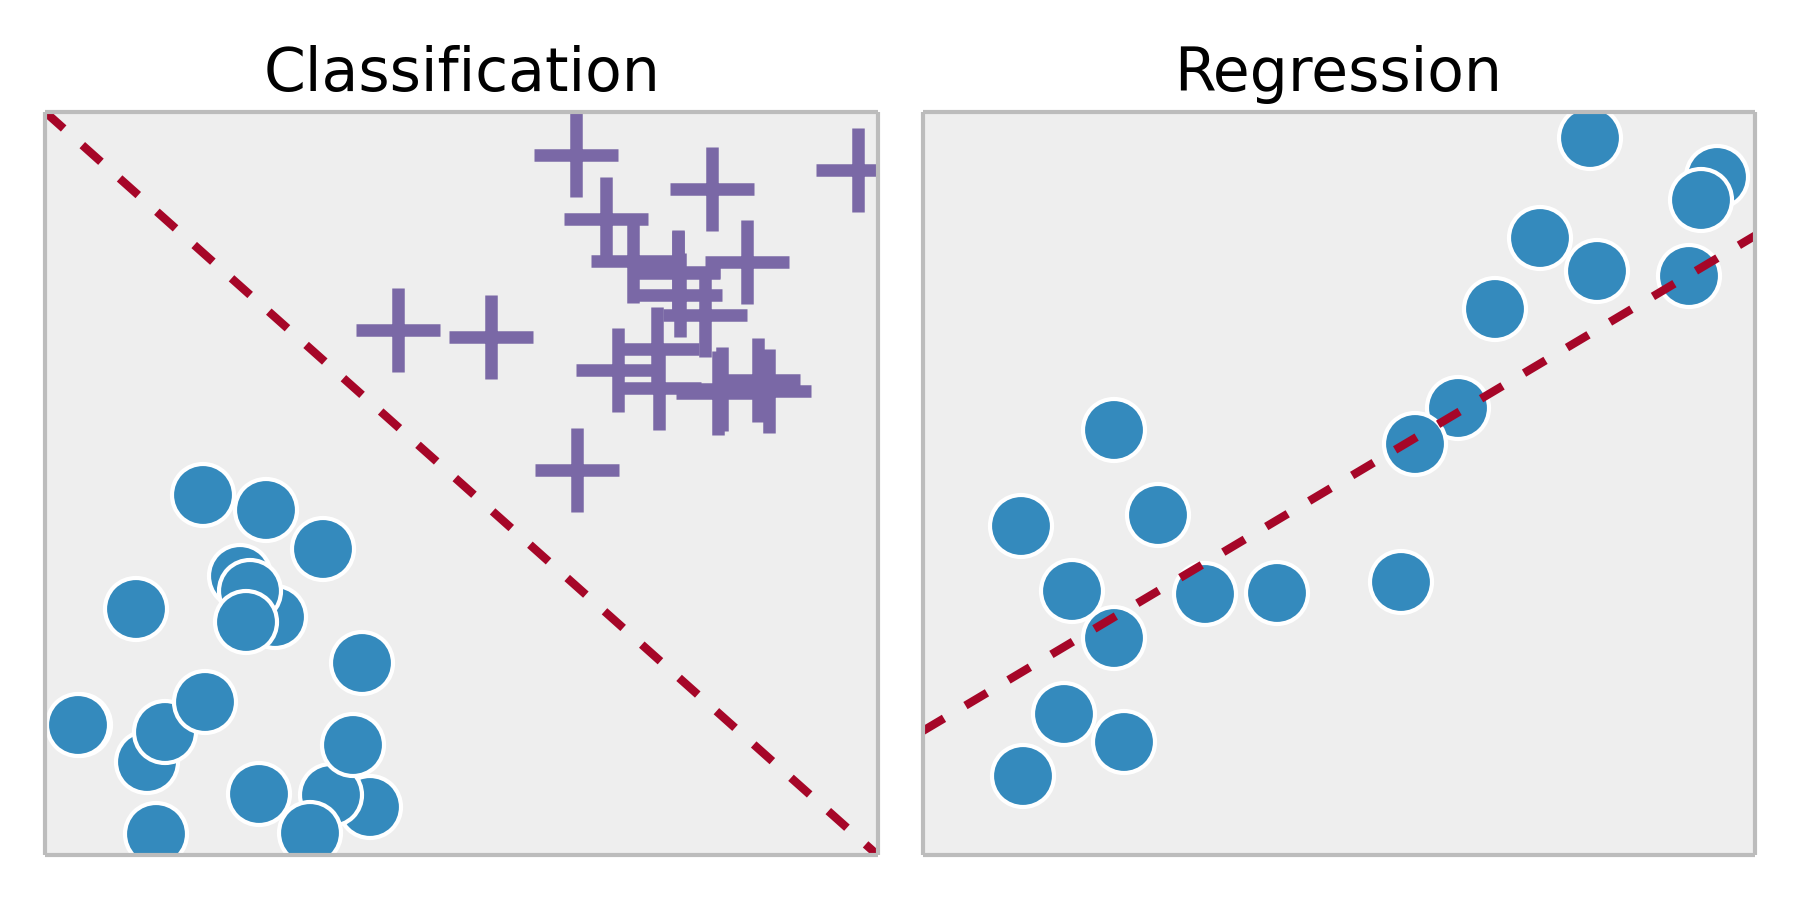

_Регрессия_ - таргет непрерывен
- Предсказание цен на дома
- Предсказание спроса на товары
- ...


_Классификация_ - Таргет принимает 2 (иногда k) значений
- Кредитный скоринг: вернет кредит (target=0) или нет (target=1)
- Определение вида животного по фото (0 - лев, 1 - пантера, 2 - леопард, ... , k - гепард) 
- ...

**Обучение без учителя** = нет целевой переменной:
- Разделение данных на группы
- ...
_______________

**Обучение с подкреплением** - испытуемая система (агент) обучается, взаимодействуя с некоторой средой.
<table><tr>
<td> <img src="images/openai1.gif" style="width: 600px;"/> </td>
<td> <img src="images/unnamed.gif" style="width: 450px;"/> </td>
</tr></table>

_________
**Что относится к классификации?**<br>
1. Прогноз оценки студента по пятибалльной шкале на экзамене 
2. Предсказание спроса на товары
3. Поиск похожих групп пользователей
4. Разделение книг на художественные и научные

---

**ЭТАПЫ Data Science проекта:**
1. Определить бизнес проблему
2. Убедить бизнес, что ее можно и нужно решать с помощью ML
3. Перевести бизнес проблему в ML-задачу
4. Выбрать подходящие ML и бизнес метрики
---------------------------------------------------------------------------
5. Загрузка данных
6. EDA: визуализация данных (вебинар 3)
7. Очистка данных и feature engineering (вебинар 2)
8. **_Разбиение данных на train и test_**
9. **_Построение ML моделей_**
10. **_Оценка качества ML моделей и выбор наилучшей_**

---------------------------------------------------------------------------
11. Доказать бизнес-заказчику, что модель хорошо работает
12. Внедрение модели в production
13. Улучшение модели
14. Поддержка модели

---

**Подключение библиотек и скриптов**

In [189]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [190]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [191]:
DATASET_PATH = './housing_2.csv'
PREPARED_DATASET_PATH = './housing_prepared_2.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

# Шаг 1. Загрузка данных <a class='anchor' id='load'>

По **reduce_mem_usage** смотри вебинар 3

In [192]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [193]:
df = pd.read_csv(DATASET_PATH, sep=';')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 2.83 MB
Memory usage after optimization is: 1.06 MB
Decreased by 62.5%


longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -122.230003  37.880001                41.0        880.0           129.0   
1 -122.220001  37.860001                21.0       7099.0          1106.0   
2 -122.239998  37.849998                52.0       1467.0           190.0   
3 -122.250000  37.849998                52.0       1274.0           235.0   
4 -122.250000  37.849998                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

   bedroom_share  population_per_room  <1H OCEAN  INLAND  ISLAND  NEAR BAY  \
0      14.659091             0.365909          0       0       0         1   
1      15.579659             0.338217          0       0       0         1   
2      12.951602             0.338105          0       0       0         1   
3      18.445839             0.437991          0       0       0         1   
4      17.209589             0.347265          0       0       0         1   

   NEAR OCEAN  median_rooms  
0           0        2083.0  
1           0        2083.0  
2           0        2083.0  
3           0        2083.0  
4           0        2083.0

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   longitude            20640 non-null  float32 
 1   latitude             20640 non-null  float32 
 2   housing_median_age   20640 non-null  float32 
 3   total_rooms          20640 non-null  float32 
 4   total_bedrooms       20640 non-null  float32 
 5   population           20640 non-null  float32 
 6   households           20640 non-null  float32 
 7   median_income        20640 non-null  float32 
 8   median_house_value   20640 non-null  float32 
 9   ocean_proximity      20640 non-null  category
 10  bedroom_share        20640 non-null  float32 
 11  population_per_room  20640 non-null  float32 
 12  <1H OCEAN            20640 non-null  int8    
 13  INLAND               20640 non-null  int8    
 14  ISLAND               20640 non-null  int8    
 15  NEAR BAY           

# Шаг 2. EDA и очистка данных  <a class='anchor' id='eda'>

*В этом вебинаре мы не будем останавливаться на EDA, но в проекте это сделать нужно - __смотри вебинар 3__

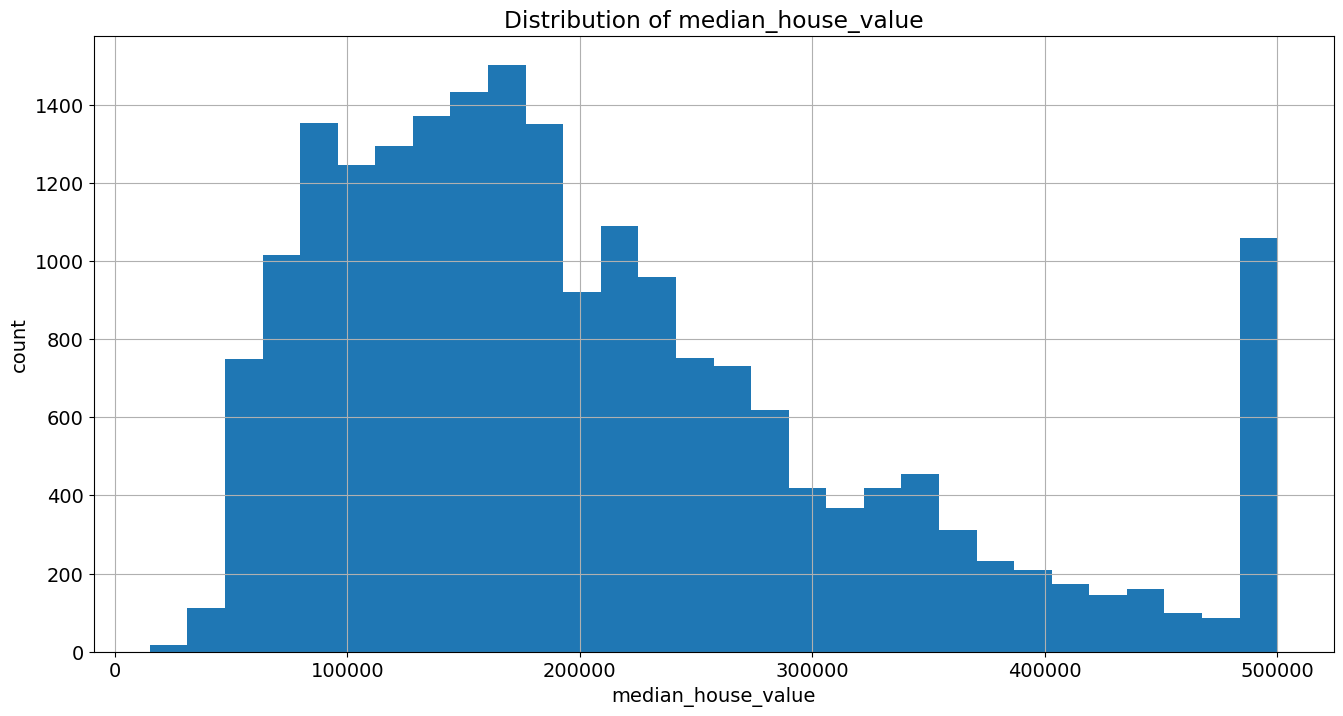

In [195]:
plt.figure(figsize = (16, 8))

df['median_house_value'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

In [196]:
df = df[df['median_house_value'] <= 500000].reset_index()

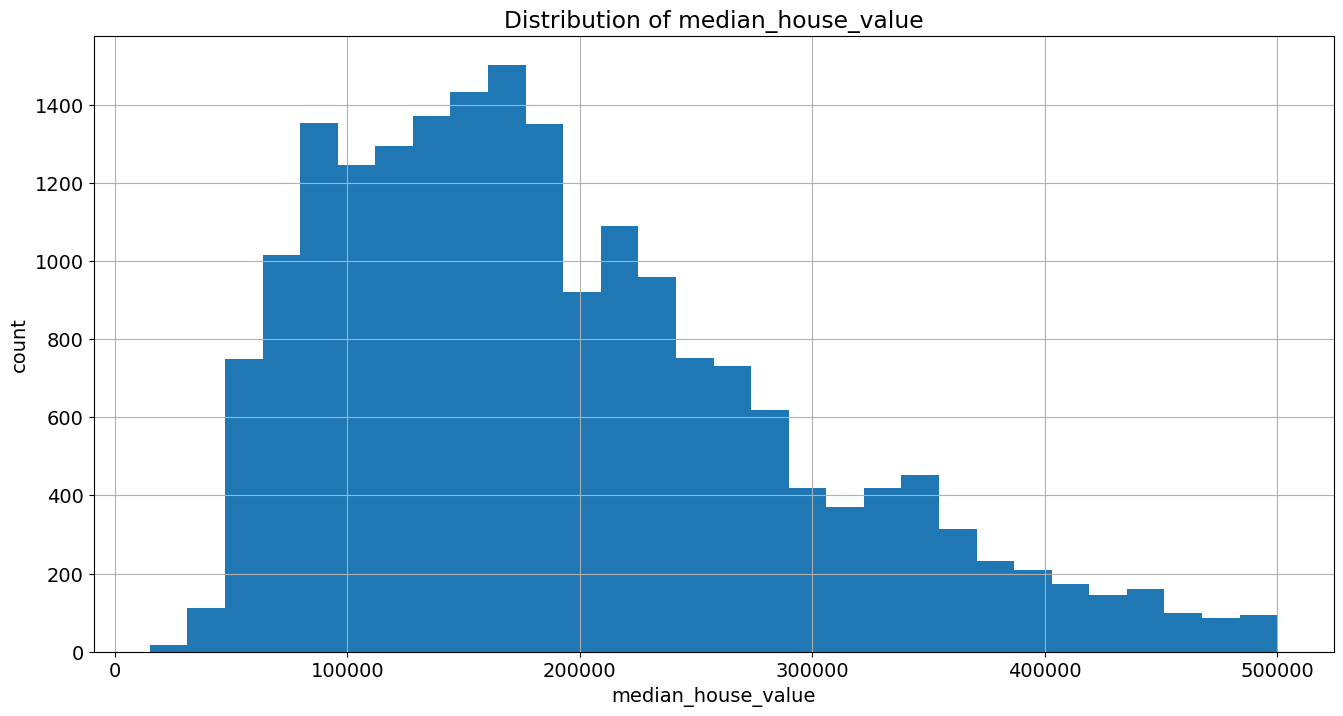

In [197]:
plt.figure(figsize = (16, 8))

df['median_house_value'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('median_house_value')

plt.title('Distribution of median_house_value')
plt.show()

# Шаг 3: Очистка данных и Feature engineering  <a class='anchor' id='preprocess'>

*Пример вы можете посметреть в вебинаре 2: __class DataPipeline__

In [198]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        # <your code>
        
    def fit(self, df):
        """Сохранение статистик"""
        # <your code>
        
    def transform(self, df):
        """Трансформация данных"""
        # <your code>

---

**Оставим признаки, которые необходимы для модели**

In [199]:
df.columns.tolist()

['index',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'bedroom_share',
 'population_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN',
 'median_rooms']

In [200]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                 'households', 'median_income', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']

target_name = 'median_house_value'

In [201]:
df = df[feature_names + [target_name]]
df.head()

longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -122.230003  37.880001                41.0        880.0           129.0   
1 -122.220001  37.860001                21.0       7099.0          1106.0   
2 -122.239998  37.849998                52.0       1467.0           190.0   
3 -122.250000  37.849998                52.0       1274.0           235.0   
4 -122.250000  37.849998                52.0       1627.0           280.0   

   population  households  median_income  <1H OCEAN  INLAND  NEAR BAY  \
0       322.0       126.0         8.3252          0       0         1   
1      2401.0      1138.0         8.3014          0       0         1   
2       496.0       177.0         7.2574          0       0         1   
3       558.0       219.0         5.6431          0       0         1   
4       565.0       259.0         3.8462          0       0         1   

   NEAR OCEAN  median_house_value  
0           0            452600.0  
1           0            358500.0  
2           0            352100.0  
3           0            341300.0  
4           0            342200.0

**Стандартизация признаков** 

In [202]:
# выделяем численные признаки
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'float16']).columns.tolist()
feature_names_for_stand

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

Стандартизация - нужна для нормализации данных

In [203]:
# масштабирование признаков (важно использовать если модель зависит от расстояния между данными)
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min) -> [0, 1]

# StandardScaler() Для каждой фичи х делает: (x - mean) / std      -> mean = 0, std = 1

# RobustScaler() используем межквантильный размах (от Q1 до Q3) - неочень чувствителен к выбросам

scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [204]:
stand_features

array([[-1.3296409 ,  1.0366442 ,  1.0243417 , ..., -0.98255783,
        -0.9789465 ,  2.9603806 ],
       [-1.3246547 ,  1.0273402 , -0.6042318 , ...,  0.85655695,
         1.6615938 ,  2.9452236 ],
       [-1.3346232 ,  1.0226873 ,  1.920057  , ..., -0.8286348 ,
        -0.8458758 ,  2.2803533 ],
       ...,
       [ 0.6195371 , -1.0799824 ,  1.920057  , ..., -0.618981  ,
        -0.5562513 , -0.1822132 ],
       [ 0.6195371 , -1.0753312 ,  1.920057  , ..., -0.96575016,
        -0.8902327 , -0.5990307 ],
       [ 0.53977364, -1.0334638 ,  0.04719759, ..., -0.8940963 ,
        -0.8563127 , -0.6830311 ]], dtype=float32)

In [205]:
stand_features.shape

(19675, 8)

In [206]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
df.shape

(19675, 13)

In [207]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0  -1.329641  1.036644            1.024342    -0.797584       -0.974311   
1  -1.324655  1.027340           -0.604232     2.053478        1.349771   
2  -1.334623  1.022687            1.920057    -0.528477       -0.829205   
3  -1.339609  1.022687            1.920057    -0.616957       -0.722159   
4  -1.339609  1.022687            1.920057    -0.455126       -0.615113   

   population  households  median_income  <1H OCEAN  INLAND  NEAR BAY  \
0   -0.982558   -0.978947       2.960381          0       0         1   
1    0.856557    1.661594       2.945224          0       0         1   
2   -0.828635   -0.845876       2.280353          0       0         1   
3   -0.773789   -0.736288       1.252288          0       0         1   
4   -0.767596   -0.631919       0.107935          0       0         1   

   NEAR OCEAN  median_house_value  
0           0            452600.0  
1           0            358500.0  
2           0            352100.0  
3           0            341300.0  
4           0            342200.0

### Сохранение  датасета

In [208]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=';')

# Шаг 4. Разбиение на train / test  <a class='anchor' id='split'>

In [209]:
X = df[feature_names]   # пространство признаков (фичей)
y = df[target_name]     # целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)


# Шаг 5. Построение моделей <a class='anchor' id='model'>

    
ML метрика - Mean Squared Error (**MSE**) 
    - MSE прямопропорциональна RMSE и R^2
    - MSE  удобно оптимизировать (брать производные)
    - MSE используется "под капотом" наших ML моделей



Бизнес метрика - **R^2**, Root Mean Squared Error (**RMSE**)
    - Бизнес метрика интерпретируема
    - Понятна бизнесу
    - Ее мы показываем бизнесу
    - RMSE - насколько, в среднем, $ мы ошибаемся при предсказании цен 
    - R^2 принимает значения от 0 до 1, если 1 - все предсказания идеальны. Можно сказать, что это "точность" модели

Лучшая модель - модель с наименьшей MSE на test 

 $$MSE = \frac{1}{n}  \sum{(y - y_{pred})^2}$$

$$RMSE = \sqrt{\frac{1}{n}  \sum{(y - y_{pred})^2}}$$

$$R^2 = 1 - \frac{\frac{1}{n}\sum{(y - y_{pred})^2}}{\frac{1}{n}\sum{(y - y_{mean})^2}}$$

In [210]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Правильные значения')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### 5.1 Linear Regression  <a class='anchor' id='linear'>

* Задача регрессии: предсказание (прогнозирование) целевого признака по входным параметрам.
* Представление - линейное уравнение, объединяющее определенный набор входных значений (X) решений, к которому является прогнозируемый вывод для этого набора входных значений (y)

<img src='images/linear_reg.png' width=500px>

$$price_{pred} = a_0 + a_1 * households + a_2 * rooms$$

Подробное объяснение [здесь](https://codecamp.ru/blog/introduction-to-linear-regression-python/)

$$Loss = MSE = \frac{1}{n}\sum{(price - price_{pred})^2}$$

$$Loss = MSE = \frac{1}{n}\sum{(price - (a_0 + a_1 * households + a_2 * rooms))^2}$$

$dx^2 = 2x$

$d4x = 4$

Находим производные по параметрам и решим систему из 3 уравнений с 3 неизвестными:

$$\frac{dLoss}{da_0} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * 1} = 0 $$  
$$\frac{dLoss}{da_1} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * households} = 0 $$  
$$\frac{dLoss}{da_2} = \frac{1}{n}\sum{2*(price-(a_0 + a_1 *households + a_2*rooms)) * rooms} = 0 $$  

In [211]:
# np.clip([-10, 1, 100000, 1000000], a_min=10000, a_max=500000)

R2:	0.612
RMSE:	60526.389
MSE:	3663443783.716


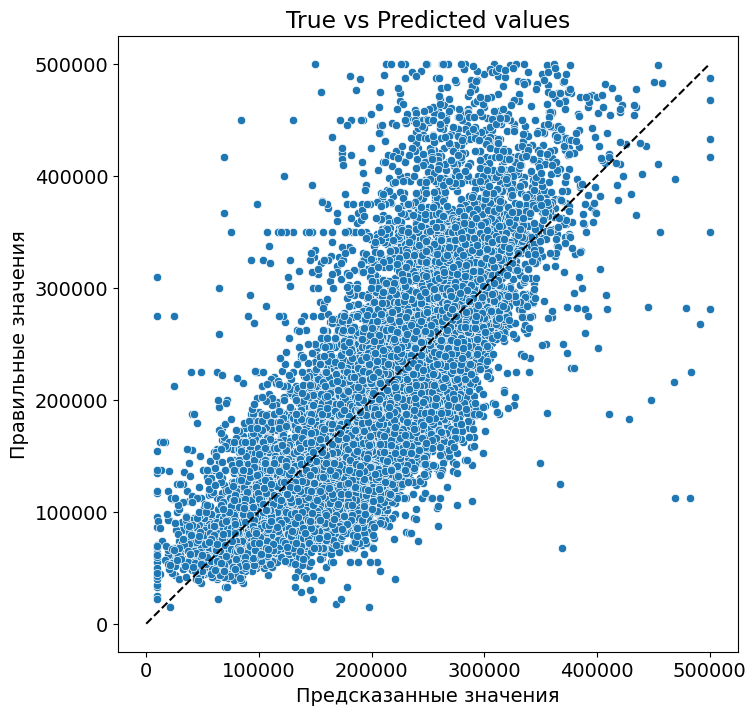

In [212]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.609
RMSE:	61780.777
MSE:	3816864408.716


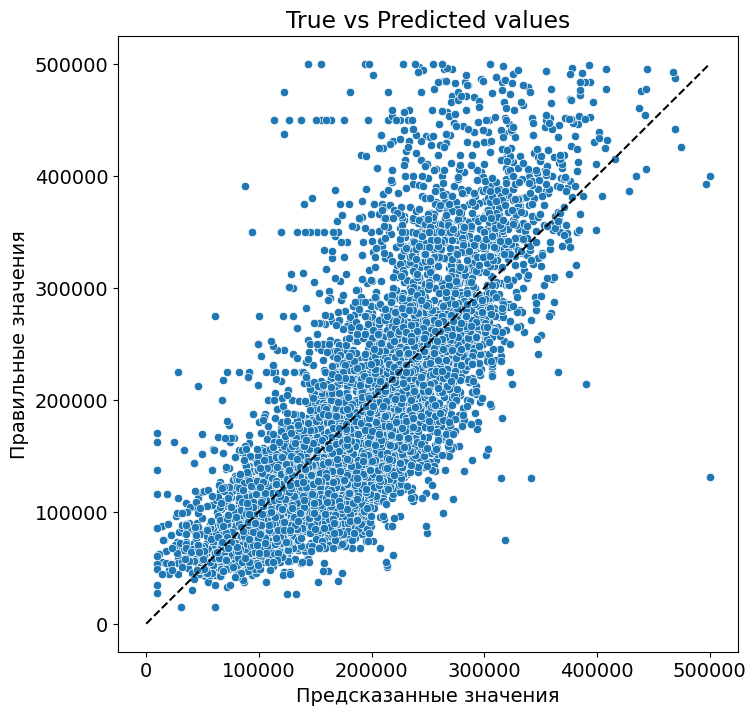

In [213]:
y_test_preds = lr_model.predict(X_test)

# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_test, y_test_preds)

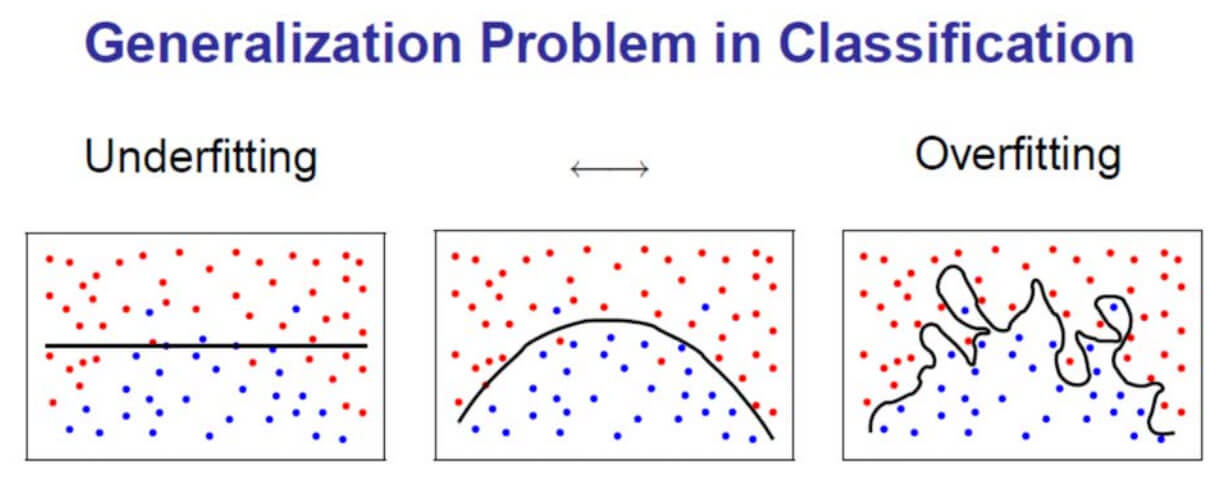

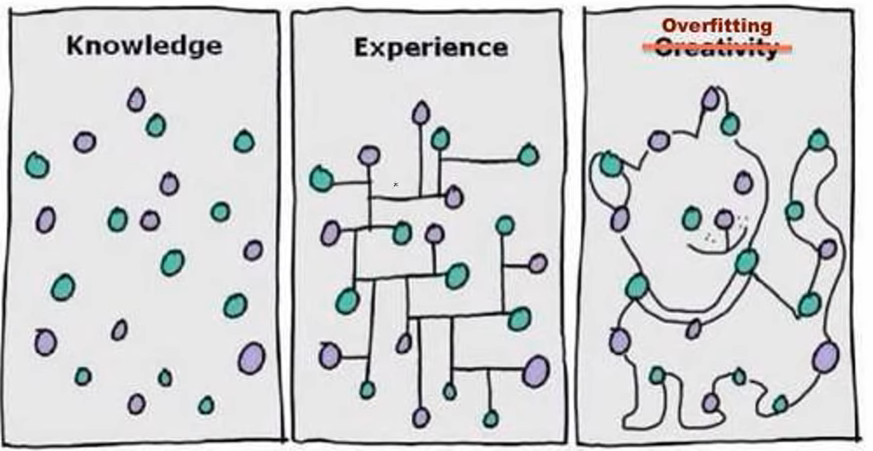

### 5.2 Decision tree  <a class='anchor' id='tree'>

Подробнее можно почитать [здесь](https://habr.com/ru/company/ods/blog/322534/)

На примере задачи: _Сколько времени человек потратит на онлайн игры?_  (0 - 24 часа/день)

<img src='images/dt_explained.png'>

- age < 15 and is_male > 0.5 ---> 5
- age < 15 and is_male <= 0.5 ---> 0
- age >= 15 ---> 1

Decision tree может моделировать зависимости такого вида:

<img src='images/dt_example.png'>

R2:	0.807
RMSE:	42657.583
MSE:	1819669414.715


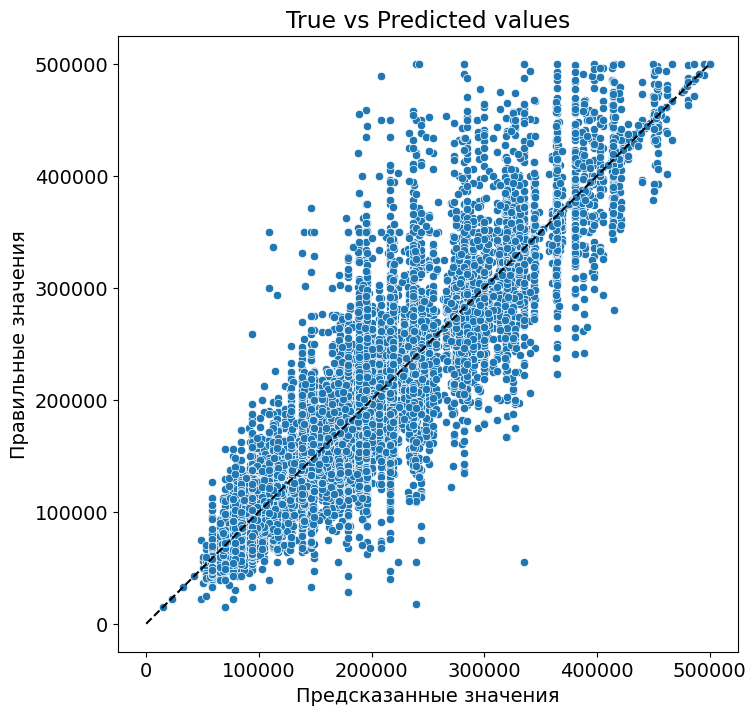

In [214]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=10, # глубина дерева  
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.657
RMSE:	57916.823
MSE:	3354358352.909


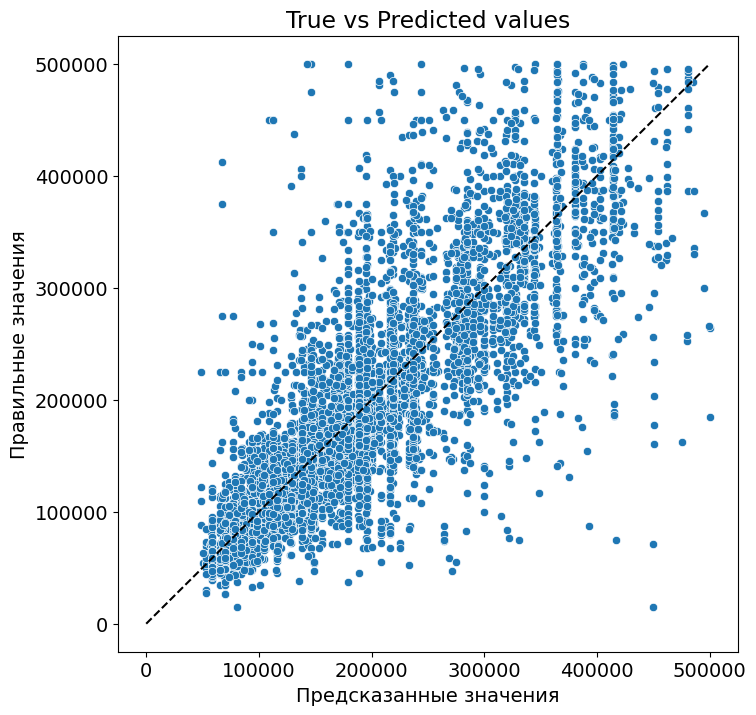

In [215]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

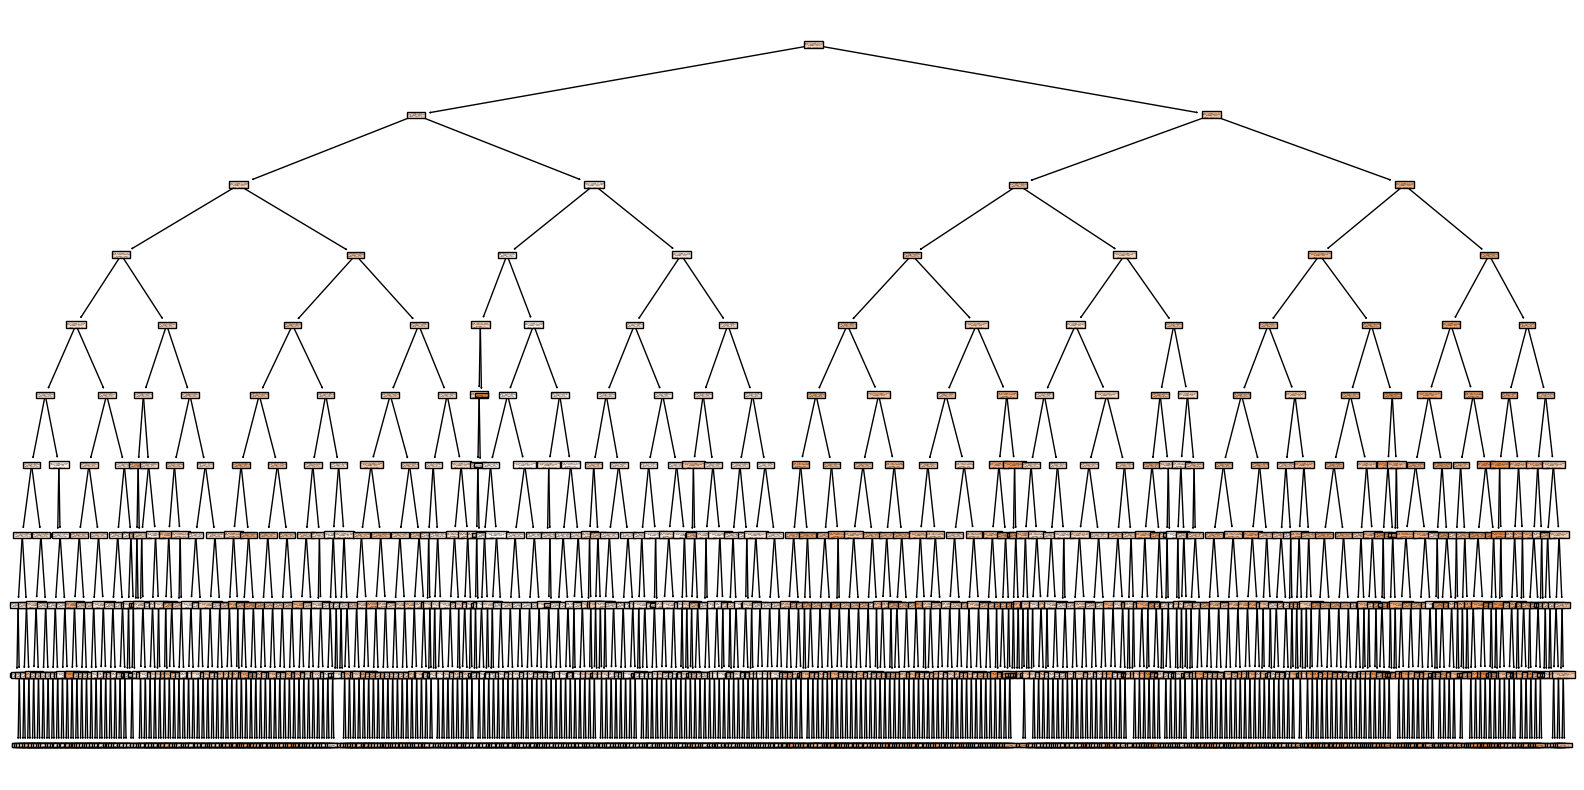

In [216]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True);

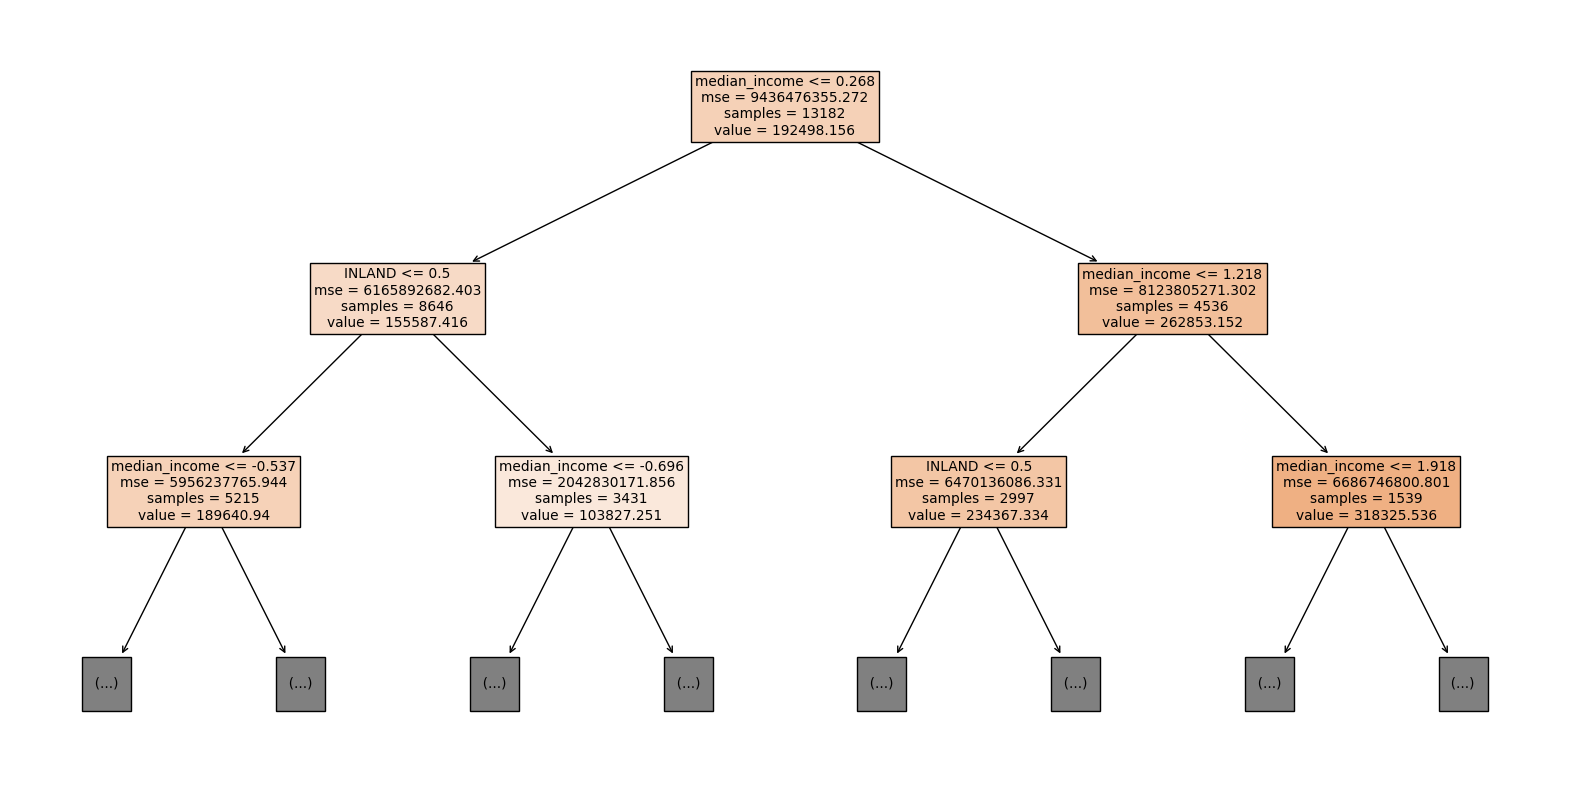

In [217]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True, max_depth=2);

### 5.3 Random Forest  <a class='anchor' id='rf'>

Про лес подробнее можно почитать [здесь](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)

**Независимо** строятся N деревьев. Их **предсказания усредняются**

Чтобы деревья получались разными добавляют элемент случайности:
- каждое дерево строят на подвыборке данных (случайно сэмплируют 70% данных)
- каждое дерево строят на подвыборке фич (случайно сэмплируют 70% фич)
- ...

<img src='images/rf_explained.png'>

Бутстрэп - выбираем из обучающей выборки k объектов с возвращением.
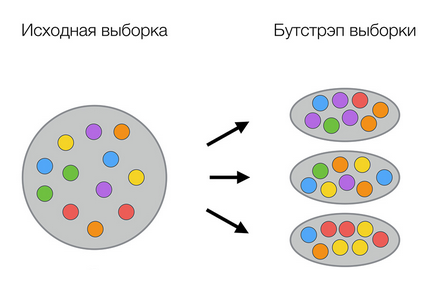
Бэггинг - Бутстрэп-агрегирование<br>
Про бэггинг и бутстрэп можно почитать [здесь](https://habr.com/ru/company/ods/blog/324402/)

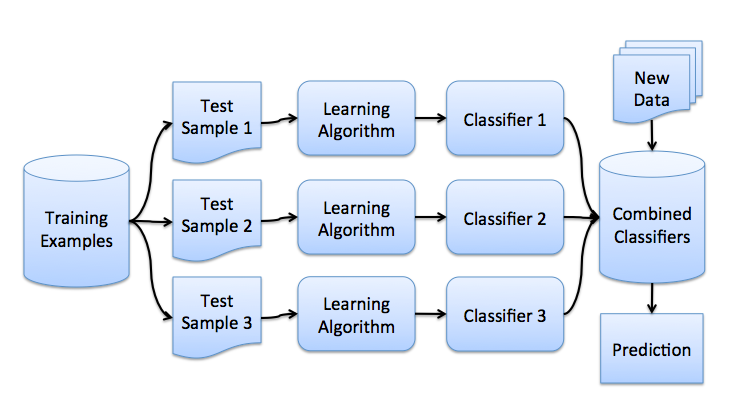

R2:	0.768
RMSE:	46766.225
MSE:	2187079767.891


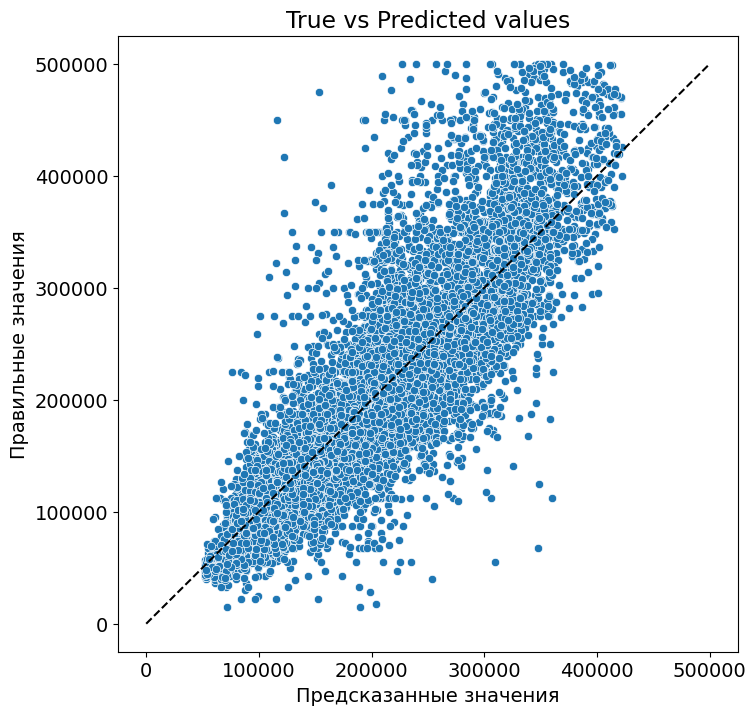

In [218]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.722
RMSE:	52090.975
MSE:	2713469629.897


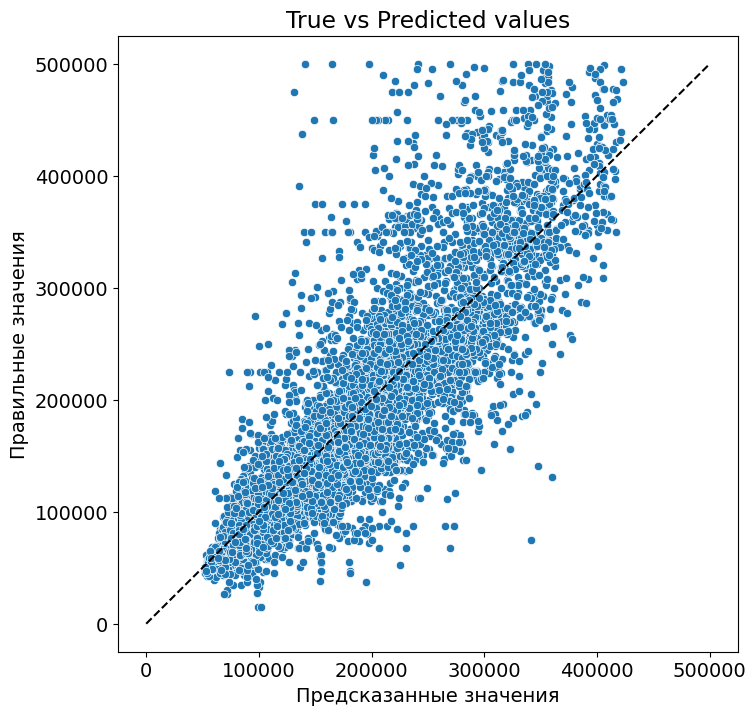

In [219]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### 5.4 Gradient Boosting decision trees  <a class='anchor' id='boost'>

Подробнее можно почитать [здесь](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d)

**Последовательно** строятся N деревьев: новое дерево обучается на ошибках предыдущих. **Предсказания деревьев суммируются**

<img src='images/gb_explained.png'>

In [220]:
y = np.array([10, 20, 30, 5, 10])

# Первое дерево
y_pred_1 = np.array([8, 25, 34, 10, 3])
error_1 = y - y_pred_1

error_1

array([ 2, -5, -4, -5,  7])

In [221]:
gb_pred = y_pred_1
r2(y, gb_pred)

0.7025

In [222]:
# Второе дерево: таргет = ошибки первого (error_1)
y_2 = error_1
y_pred_2 = np.array([1, -4, -2, -1, 3])

error_2 = y_2 - y_pred_2
error_2

array([ 1, -1, -2, -4,  4])

In [223]:
gb_pred = y_pred_1 + y_pred_2
r2(y, gb_pred)

0.905

In [224]:
# Третье дерево: таргет = ошибки второго (error_2)
y_3 = error_2
y_pred_3 = np.array([0, -1, -1, -1, 1])

error_2 = y_3 - y_pred_3
error_2

array([ 1,  0, -1, -3,  3])

In [225]:
gb_pred = y_pred_1 + y_pred_2 + y_pred_3
r2(y, gb_pred)

0.95

---

R2:	0.897
RMSE:	31148.463
MSE:	970226732.155


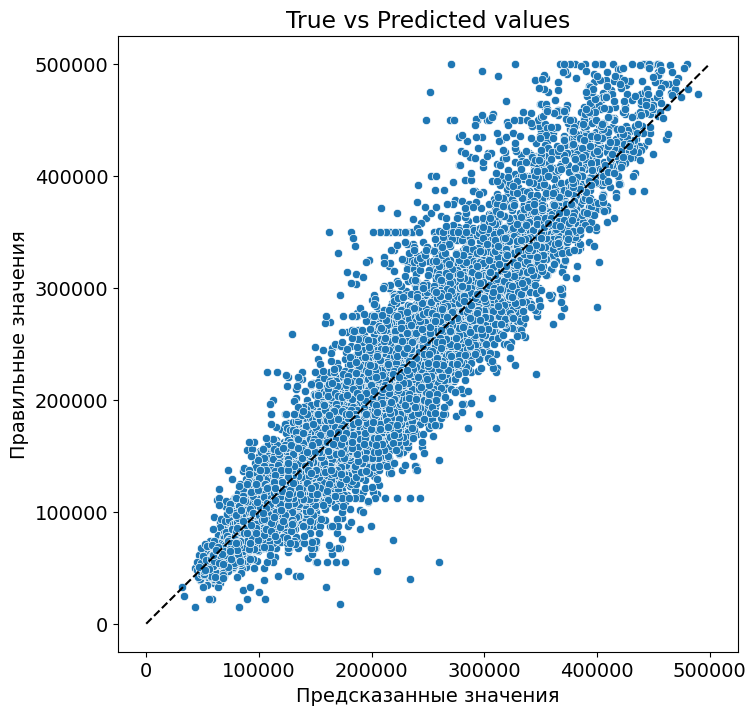

In [226]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.799
RMSE:	44364.776
MSE:	1968233321.691


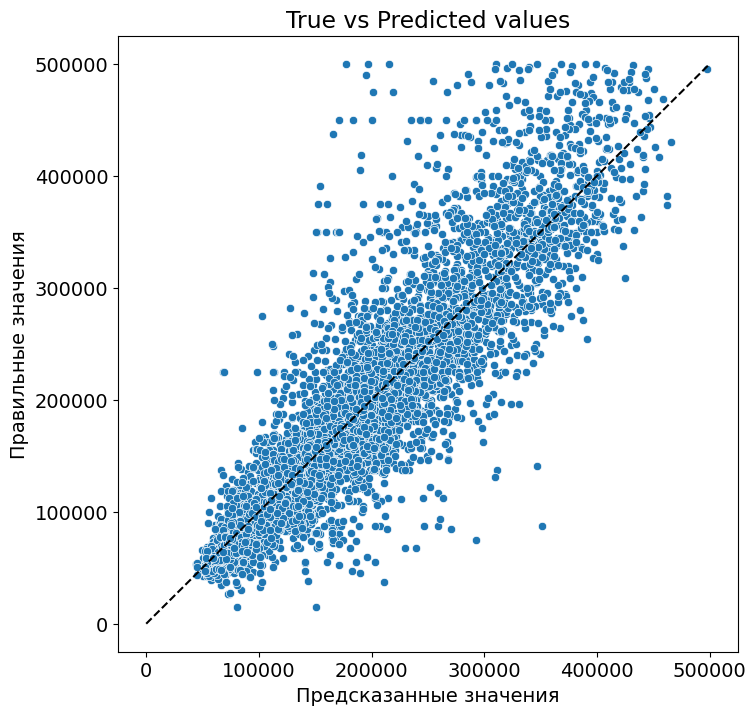

In [227]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

# Шаг 6.* Настройка и оценка финальной модели  <a class='anchor' id='cross_val'>

!!!  кросс-валидация проходит на трейне, test не трогаем  !!!

[Кросс валидация](https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85) и подбор гиперпараметров

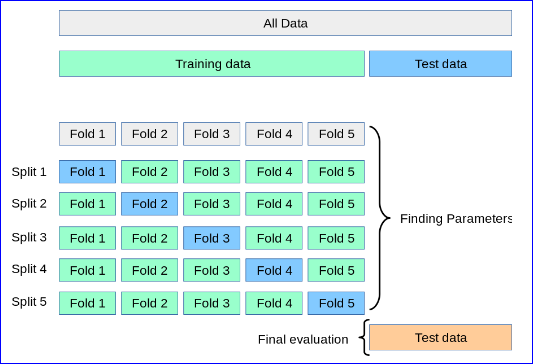

In [228]:
X_train.shape[0] // 5

2636

In [229]:
X_train.reset_index(inplace=True, drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)

In [230]:
# Одну модель (одни и те же гиперпараметры)

# Iteration_1
X_train__val_1 = X_train.iloc[:2500]
y_train__val_1 = y_train.iloc[:2500]

X_train__train_1 = X_train.iloc[2500:]
y_train__train_1 = y_train.iloc[2500:]


# обучаем модель на X_train__train_1, y_train__train_1
# предсказываем на X_train__val_1, y_train__val_1
# R2__1 = r2(y_pred__val_1, y_train__val_1) = 0.83


# Iteration_2
X_train__val_2 = X_train.iloc[2500:5000]
y_train__val_2 = y_train.iloc[2500:5000]

X_train__train_2 = X_train.drop(np.arange(2500, 5000))
y_train__train_2 = y_train.drop(np.arange(2500, 5000))


# обучаем модель на X_train__train_2, y_train__train_2
# предсказываем на X_train__val_2, y_train__val_2
# R2__2 = r2(y_pred__val_2, y_train__val_2) = 0.87


# ...

# R2 = [0.83, 0.87, 0.79, 0.8, 0.91]

In [231]:
R2 = np.array([0.83, 0.87, 0.79, 0.8, 0.91])
np.mean(R2)

0.8400000000000001

In [232]:
# Сделали то же самое для модели с другими гиперпараметрами

In [233]:
# cross val R2 model_1 = 0.84
# cross val R2 model_2 = 0.87 - выбираем эту модель (ее гиперпараметры)

In [234]:
# ЗАНОВО Обучаем модель с наилучшими гиперпараметрами (те, которые дают максимальный cross val R2) на ВСЕМ train

---

In [235]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [236]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

CPU times: total: 57.6 s
Wall time: 3min 33s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [237]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.639143      0.236446         0.012597        0.003266   
1       4.095212      0.348020         0.014604        0.002246   

  param_max_depth param_n_estimators                                 params  \
0               3                 50   {'max_depth': 3, 'n_estimators': 50}   
1               3                100  {'max_depth': 3, 'n_estimators': 100}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.672453           0.693378           0.680593           0.690490   
1           0.725434           0.747829           0.731086           0.745715   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.660996         0.679582        0.011888               16  
1           0.713352         0.732683        0.012869               15

In [238]:
gs.best_params_

{'max_depth': 7, 'n_estimators': 400}

In [239]:
gs.best_score_

0.8052746386536898

**Обучение и оценка модели**

In [240]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=400)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          n_estimators=400, random_state=42)

R2:	0.958
RMSE:	19873.345
MSE:	394949841.427


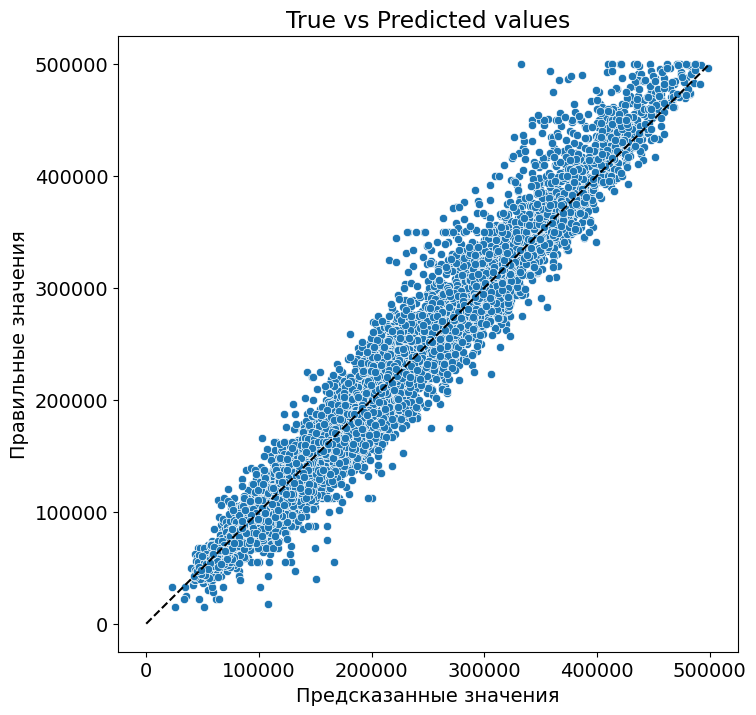

In [241]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

R2:	0.808
RMSE:	43337.229
MSE:	1878115401.17


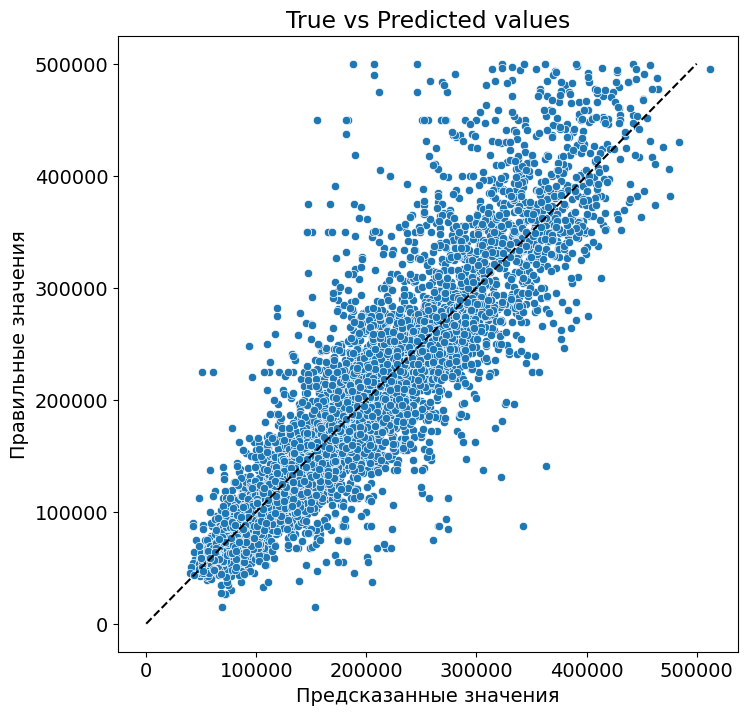

In [243]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds, save=True)

# Шаг 7.* Анализ прогнозов <a class='anchor' id='pred'>

**Важность признаков**

In [244]:
final_model.feature_importances_

array([0.11740274, 0.11389393, 0.04085088, 0.02800152, 0.02582458,
       0.03693123, 0.01997633, 0.44046009, 0.00364721, 0.16361846,
       0.00139774, 0.00799528])

In [245]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

**Топ-3 фичи**

In [246]:
feature_importances.head(3)

feature_name  importance
7  median_income    0.440460
9         INLAND    0.163618
0      longitude    0.117403

**Худшие 3 фичи**

In [247]:
feature_importances.tail(3)

feature_name  importance
11   NEAR OCEAN    0.007995
8     <1H OCEAN    0.003647
10     NEAR BAY    0.001398

In [248]:
feature_importances.to_csv(REPORTS_FILE_PATH + 'feature_importances.csv', index=False)

# Шаг 8. Сохранение модели <a class='anchor' id='save'>

In [249]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [250]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [251]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          n_estimators=400, random_state=42)

In [252]:
import sklearn
print(sklearn.__version__)

1.0.2


In [253]:
pip freeze

absl-py==1.4.0
aiohttp==3.9.5
aiosignal==1.3.1
anyio==4.3.0
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asgiref==3.8.1
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
async-timeout==4.0.3
attr==0.3.1
attrs==23.2.0
Automat==22.10.0
azure-core==1.30.1
azure-storage-blob==12.20.0
Babel==2.15.0
beautifulsoup4==4.12.3
black==23.1.0
bleach==5.0.1
boto==2.49.0
boto3==1.34.110
botocore==1.34.110
boxing==0.1.4
bs4==0.0.2
cachetools==5.3.3
certifi==2024.2.2
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.3
clickhouse-driver==0.2.7
cloudpickle==3.0.0
colorama==0.4.6
comm==0.2.1
constantly==23.10.4
contourpy==1.0.7
cryptography==42.0.6
cssselect==1.2.0
cycler==0.11.0
datasets==2.18.0
DateTime==5.5
debugpy==1.8.1
decorator==5.1.1
deeppavlov==1.6.0
defusedxml==0.7.1
dill==0.3.8
distro==1.9.0
Django==3.2.25
django-annoying==0.10.6
django-cors-headers==3.6.0
django-csp==3.7
django-debug-toolbar==3.2.1
django-environ==0.10.0
django-extensions==3.1.0
django-filter=

# Обобщение  <a class='anchor' id='full'>

----

## $$Метрики$$
<img src='images/classif&regr.png'>

In [257]:
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

x = [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
y = [0, 10, 15]
knn = KNeighborsRegressor(n_neighbors=1)
c = BaggingRegressor(knn, n_estimators=100)
c.fit(x, y)
c.predict(x)

array([8.3, 8.3, 8.3])

[Машинное обучение для людей](https://zen.yandex.ru/media/id/5c228ab268a70a00adaf792a/mashinnoe-obuchenie-dlia-liudei-5c23782132121100a94a4417)
<img src=https://avatars.mds.yandex.net/get-zen_doc/1056701/pub_5c23782132121100a94a4417_5c2378bab8997d00a95fbbcc/scale_2400 width=800px>

___________
<img src='images/ds_pipeline.png'>

## Курсовая
**Требования к курсовому:**

Нужно будет оформить ноутбук с основными этапами:
1. подготовка данных
    * анализ
    * визуализация
    * обработка выбросов
    * обработка пропусков
    * генерация фичей
2. обучение модели
3. проверка качества модели

Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)


________________________
За шаблон оформления курсовой можно взять ноутбук, который будем разбирать на уроке 10: https://www.kaggle.com/julichitai/baseline


*Что обязательно стоит попробовать:*
1. Тщательный анализ данных
2. Поиск странных значений
3. Предобработка данных
4. Генерация разнообразных признаков
5. Разные модели и их разные гиперпараметры

*Что не стоит пробовать:*
1. Кластеризация
2. Модели понижения размерности